In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import math
import itertools
from collections import defaultdict
from operator import itemgetter

import torch
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from torch import nn
from torch.nn import functional as F

from phoneme_lm import PhonemeLM, build_vocab, encode_pronunciation
from utils import load_data, split_data

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [4]:
df = load_data(True)
len(df)

124996

In [5]:
phoneme_to_idx, idx_to_phoneme = build_vocab(df.pronunciation.values)
df['phoneme_ids'] = df.pronunciation.apply(lambda pronunciation: encode_pronunciation(pronunciation, phoneme_to_idx))

In [6]:
df['pronunciation_string'] = df.pronunciation.apply(' '.join)
df['length'] = df.pronunciation.apply(len)

In [7]:
train_df, dev_df, test_df = split_data(df, dev_proportion=.2, test_proportion=.01)

In [8]:
len(train_df), len(dev_df), len(test_df)

(98746, 25000, 1250)

In [9]:
%%time

lm = PhonemeLM(phoneme_to_idx, idx_to_phoneme, embedding_dimension=10, rnn_hidden_dimension=20, batch_size=1028)
lm.fit(train_df.pronunciation, dev_df.pronunciation, epochs=10)

Epoch 1: train loss: 1.2725	assess loss: 1.7832
Epoch 2: train loss: 0.9450	assess loss: 1.4279
Epoch 3: train loss: 0.8537	assess loss: 1.3058
Epoch 4: train loss: 0.8058	assess loss: 1.2370
Epoch 5: train loss: 0.7715	assess loss: 1.1880
Epoch 6: train loss: 0.7440	assess loss: 1.1493
Epoch 7: train loss: 0.7236	assess loss: 1.1163
Epoch 8: train loss: 0.7056	assess loss: 1.0902
Epoch 9: train loss: 0.6894	assess loss: 1.0653
Epoch 10: train loss: 0.6738	assess loss: 1.0417
CPU times: user 37min 45s, sys: 1min 29s, total: 39min 14s
Wall time: 8min 14s


In [18]:
%%time

df['probability'] = df.pronunciation.apply(lambda pronunciation: lm.calculate_probability(pronunciation))

CPU times: user 2min 24s, sys: 377 ms, total: 2min 24s
Wall time: 2min 26s


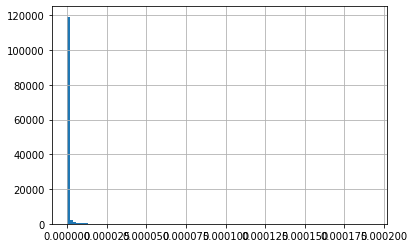

In [19]:
df.sort_values('probability', ascending=False, inplace=True)
df.probability.hist(bins=100)

### GENERATE PRONUNCIATIONS ###

In [17]:
for _ in range(10):
    pronunciation = lm.generate(100, temperature=None)
    pronunciation_string = ' '.join(pronunciation)
    matches = df[df.pronunciation_string == pronunciation_string]
    
    print(pronunciation_string)
    if len(matches) > 0:
        print('\t', matches.iloc[0]['word'], len(matches), 'total')
    print()

L UH0 EH1 Z

HH AA1 OW1 L

S T UW2 S AH0 T IY2 L AH0 N V

SH EH0 M AH0 R S AH0 D

N ER1 ER0 S

OW0 M ER0 S AH0 S

R IY1 L N

N R AH0 M IH0 N AH0 D

D EH1 S F OW0 AH0 K T T

D P AH1 K AE2 R IY0



### Play with Embeddings ###

In [ ]:
emb_one = get_embedding(lm, phoneme_to_id, id_to_phoneme, 'K')

for phoneme, phoneme_id in phoneme_to_id.items():
    emb_two = get_embedding(lm, phoneme_to_id, id_to_phoneme, phoneme)
    score = cosine_similarity(emb_one, emb_two)

In [ ]:
# Group phonemes. Try k-means

L = [1, 2, 3, 4]
list(itertools.combinations(L, 2))


phonemes = set(phoneme_to_id) - {START, END, PAD}
records = []
for phoneme_one, phoneme_two in itertools.combinations(phonemes, 2):
#     print(phoneme_one, phoneme_two)
    emb_one = get_embedding(lm, phoneme_to_id, id_to_phoneme, phoneme_one)
    emb_two = get_embedding(lm, phoneme_to_id, id_to_phoneme, phoneme_two)
    records.append({
        'p1': phoneme_one,
        'p2': phoneme_two,
        'similarity':cosine_similarity(emb_one, emb_two).item()
    })

df = pd.DataFrame.from_records(records)

In [13]:
embeddings = lm.embeddings
normed_embeddings = normalize(embeddings)

num_clusters = 10
kmeans = KMeans(num_clusters)
kmeans.fit(normed_embeddings)

# ordered_phonemes = sorted(phoneme_to_idx, key=phoneme_to_idx.get)

grouped = defaultdict(set)
for idx, label in enumerate(kmeans.labels_):
    phoneme = lm.vocab[idx]
    grouped[label].add(phoneme)
grouped

defaultdict(set,
            {3: {'<PAD>', 'AA1', 'ER2', 'EY1', 'IY1', 'OW1', 'T', 'UW'},
             6: {'<W>',
              'AE1',
              'AH0',
              'EH0',
              'IH1',
              'IY2',
              'OW2',
              'R',
              'UW1',
              'UW2'},
             2: {'</W>', 'AW1', 'AY1', 'ER1', 'HH', 'K', 'UH1'},
             8: {'AO2', 'G', 'IH2', 'OY2', 'TH', 'UW0'},
             4: {'AE0',
              'AO0',
              'AO1',
              'AW0',
              'EH1',
              'EY0',
              'EY2',
              'F',
              'IH0',
              'M',
              'P',
              'UH2'},
             7: {'AA2', 'AE2', 'AY0', 'CH', 'JH', 'L', 'N', 'S'},
             9: {'B', 'Y', 'ZH'},
             1: {'AA0', 'AH1', 'AH2', 'AW2', 'ER0', 'UH0'},
             0: {'D', 'DH', 'EH2', 'OY0', 'SH', 'V', 'W', 'Z'},
             5: {'AY2', 'IY0', 'NG', 'OW0', 'OY1'}})

In [16]:
# For consonants
# - voicing
# - place: bilabial, dental, alveolar, palatal, velar
# - manner: stop, fricative, nasal

# For vowels
# - front/back
# - closed/open
# - rounding

# General
# - syllabic

# TODO: combine multiple vectors together, e.g. {B, G, V} for voiced
voicing = lm.embedding_for('B') - lm.embedding_for('P')
forwarding = lm.embedding_for('P') - lm.embedding_for('K')
frication = lm.embedding_for('F') - lm.embedding_for('P')

new = lm.embedding_for('TH') + voicing
new = lm.embedding_for('K') + voicing
# new = lm.embedding_for('T') + frication

phoneme_to_sim = {}
for phoneme in phoneme_to_idx:
    this_embs = lm.embedding_for(phoneme)
    sim = cosine_similarity(new, this_embs).item()
    phoneme_to_sim[phoneme] = sim

sorted(phoneme_to_sim.items(), key=lambda p: -p[1])[:3]

[('B', 0.765091598033905),
 ('IH1', 0.5700035095214844),
 ('K', 0.5456680059432983)]

In [ ]:
from phoneme_lm import START, END, PAD
# TODO: finish this
def analogy(lm, a, b, c):
    emb_a = lm.embedding_for(a)
    emb_b = lm.embedding_for(b)
    emb_c = lm.embedding_for(c)
    
    all_phonemes = set(lm.vocab) - {START, END, PAD}
    
    phoneme_to_diff = {}
    for phoneme in all_phonemes:
        if phoneme in {a, b, c}:
            continue
        
        emb = lm.embedding_for(phoneme)
        first = emb_a - emb_b
        second = emb_c - emb
        diff = abs(first - second)
        phoneme_to_diff[phoneme] = diff
    return phoneme_to_diff

p2d = analogy(lm, 'P', 'B', 'K')

p2d['Y'].squeeze()